In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from sklearn.metrics import mean_squared_error, r2_score

import cvxpy as cvx

import pandas_datareader.data as web
import datetime

# Library with returns forecasting models
from PredictionModels import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting
from pypfopt import EfficientFrontier, objective_functions

Setting the data parameters

In [26]:
tickers = [
    'BTC-USD', # Bitcoin
    'SOL-USD', # Solana
    'ETH-USD', # Etherium
    'MSFT.MX', # Microsoft Corporation
    'GOOG', # Alphabet Inc. (Google)
    'WMT.MX', # Walmart Inc.
    'XOM', # Exxon Mobil Corporation
    'AZN.L', # AstraZeneca PLC
    'DIS.MX', # The Walt Disney Company
    'PG.MX', # The Procter & Gamble Company
    'KIM', # Kimco Realty Corporation
]

# Market capitalization in $Bln
caps = {
    'BTC-USD': 1751,
    'SOL-USD': 71.991,
    'ETH-USD': 191.258,
    'MSFT.MX': 52592,
    'GOOG': 1855,
    'WMT.MX': 14980,
    'XOM': 462.46,
    'AZN.L': 156.814,
    'DIS.MX': 3057,
    'PG.MX': 7980,
    'KIM': 13.991
}

start_date = '2018-01-01'
end_date = '2025-04-20'
period = '1d'

Determining the Markowitz model

In [27]:
class Markowitz(DataStore):
    def __init__(self, tickers=[], start_date = '2010-01-01', end_date = '2025-04-20', period = '1d', caps = caps):
        super().__init__(tickers, start_date, end_date, period, caps=caps)
        self.exp_returns = self.data[1].mean() * 252 # If we have daily data
        self.cov = self.data[1].cov() * 252
        self.length = self.exp_returns.shape[0]
    def optimize(self):
        """
        The function optimizes the weights using Markowitz approach
        The function returns optimized weights for Markowitz portfolio
        """
        Q = np.array(self.cov)
        q = np.array(self.exp_returns)
        # Inequalities are written as Gx <= h
        G = np.diag(-1*np.ones(self.length), 0)
        h = np.zeros(self.length, dtype=int)
        # Equality constraints are written as Ax == b
        A = np.ones(self.length, dtype=int)
        b = np.array([1])
        # Defining and solving the quandratic problem
        x = cvx.Variable(self.length)
        prob = cvx.Problem(cvx.Maximize((-1/2)*cvx.quad_form(x, Q) + q.T @ x),
            [G @ x <= h, A @ x == b])
        prob.solve()

        # Retrieving the weights
        x_values = x.value
        w = dict()
        for i in range(self.length):
            w[self.tickers[i]] = round(x_values[i], 4)

        return w

    def plot_weights(self):
        weights = self.optimize()
        fig = plt.figure(figsize=(15,5))
        plt.bar(weights.keys(), weights.values(), color='b', width=0.7)
        plt.title("Asset allocation by Markowitz model", y=1.05)
        plt.xlabel("Investment assets")
        plt.ylabel("Weights of assets in Markowitz portfolio")
        plt.grid()
        plt.show()


[*********************100%***********************]  11 of 11 completed


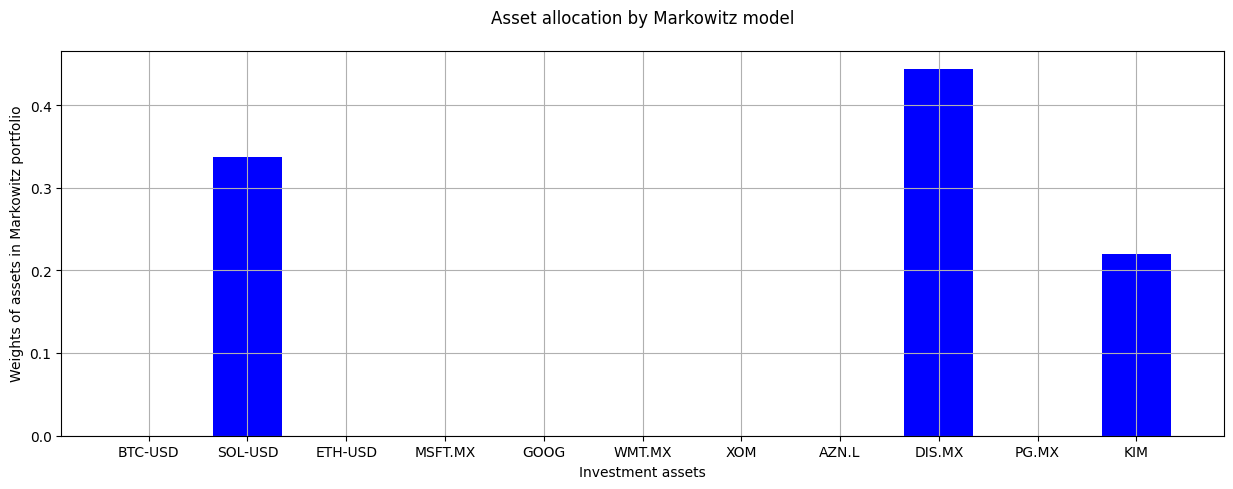

In [28]:
markowitz_model = Markowitz(tickers=tickers, start_date=start_date, end_date=end_date, period=period, caps=caps)
opt_weights = markowitz_model.optimize()
markowitz_model.plot_weights()

Black-Litterman model

In [167]:
class BlackLitterman(DataStore):
    def __init__(self, tickers=[], start_date = '2010-01-01', end_date = '2025-04-20', period = '1d', caps=caps):
        super().__init__(tickers, start_date, end_date, period, caps=caps)

        # Loading additional data of 3-month US treasure rates to calculate excess returns
        self.tickers = tickers
        self.start_date = start_date
        self.end_data = end_date
        self.t_rates = web.DataReader("TB3MS", 'fred', start=self.start_date, end=self.end_date)
        self.t_rates.reset_index(inplace=True)
        self.t_rates.rename(columns={"DATE": "Date"}, inplace=True)
        self.t_rates['TB3MS'] = self.t_rates['TB3MS'] / 100
        self.data[1].reset_index(inplace=True)
        print(self.data[1])

        # Merging the assets data and T-bill data
        self.full_data = pd.merge(self.data[1], self.t_rates, how='left', on='Date')
        # Filling in the gaps
        self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
        self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(0.0015)
        # Converting the rates into 1 day rate by dividing by 90 days
        self.full_data['TB3MS'] = self.full_data['TB3MS'] / 90

        # Dividing the data into treasury returns and other assets returns
        self.assets_returns = self.full_data[self.tickers]
        self.treasury_rate = self.full_data["TB3MS"]

    def equil_weights(self):
        """
            The function returns equilibrium weights calculated using market capitalization of assets (Yahoo Finance)
        """
        asset_weights = pd.DataFrame(self.caps.values(), index=self.caps.keys(), columns=['Cap'])
        asset_weights['Weights'] = asset_weights['Cap'].apply(lambda x: x / asset_weights['Cap'].sum())
        return asset_weights

    def implied_equil_returns(self):
        """

        """
        assets_weights = self.equil_weights()
        excess_returns = self.assets_returns.subtract(self.treasury_rate, axis=0)
        # Calculation of excess returns covariance matrix
        covar = excess_returns.cov() * 252
                # Risk-aversion parameter
        risk_aversion = 2.95
        print("risk_aversion=",risk_aversion)

        return self.implied_function(risk_aversion, covar, assets_weights['Weights'])


    def implied_function(self, risk_avers_param, sig, weights):
        """
            The function calculates equlibrium market returns

            Arg:
                - risk_avers_param (float) - risk-aversion parameter
                - sig (np.array) - covariance matrix of excess returns
                - weights (pd.Series) - equilibrium market weights
            return: equlibrium market returns
        """

        return risk_avers_param * sig.dot(weights).squeeze()


    def views_function(self):
        pass

    def function(self, predictions: dict, method: str):
        """
        The function returns the views matrix based on predictions
        """
        pass


    def function1(self):
        """
        The function does some!
        """

        pass


    def consolid_preds(self):
        """
        The function stores expected returns for each asset based on different models predictions
        """
        self.q_matrix = np.zeros(len(self.tickers))

        # Container of forecasts
        preds = np.zeros((3, len(self.tickers)))

        for i, ticker in enumerate(self.tickers):
            # Initializing the prediction models

            # DesicionTreeRegressor
            des_tree = DesicionTreeRegressorPredictor(
                ticker=ticker,
                start_date=self.start_date, # At this point I set start_date at default (dynamicaly it will differ or will be fixed)
                end_date=self.end_date,     # At this point I set end_date at default (dynamicaly it will differ)
                features_target=self.features_target
            )
            # LogisticRegression
            log_reg = LinearRegressionPredictor(
                ticker=ticker,
                start_date=self.start_date,
                end_date=self.end_date,
                features_target=self.features_target
            )

            svr_reg = SVRPredictor(
                ticker=ticker,
                start_date=self.start_date,
                end_date=self.end_date,
                features_target=self.features_target
            )


            # Making forecasts
            preds[0, i] = des_tree.make_forecast()[0]
            preds[1, i] = log_reg.make_forecast()[0]
            preds[2, i] = svr_reg.make_forecast()[0]



        return preds


In [168]:
# Checking the process
# bl = BlackLitterman(tickers, start_date, end_date, period)
# w = bl.implied_equil_returns()
# w

In [169]:
# tickers=[]
# start_date = '2010-01-01'
# end_date = '2025-04-20'
# period = '1d'
# t_rates = web.DataReader("TB3MS", 'fred', start=start_date, end=end_date)
# t_rates.reset_index(inplace=True)
# t_rates.rename(columns={"DATE": "Date"}, inplace=True)
# t_rates['TB3MS'] = t_rates['TB3MS'] / 100


# full_data = t_rates

# full_data['TB3MS'] = full_data['TB3MS'].fillna(method="ffill")
# full_data['TB3MS'] = full_data['TB3MS'].fillna(0.0015)
# full_data['TB3MS'] = full_data['TB3MS'] / 90

# assets_returns = full_data[tickers]
# treasury_rate = full_data["TB3MS"]


# asset_weights = pd.DataFrame(caps.values(), index=caps.keys(), columns=['Cap'])
# asset_weights['Weights'] = asset_weights['Cap'].apply(lambda x: x / asset_weights['Cap'].sum())
# assets_returns = full_data[tickers]
# excess_returns = assets_returns.subtract(treasury_rate, axis=0)

# covar = excess_returns.cov() * 252
#         # Risk-aversion parameter
# risk_aversion = 2.95

# prior = risk_aversion * covar.dot(asset_weights['Weights']).squeeze()

In [170]:
tickers = [
    'BTC-USD', # Bitcoin
    'SOL-USD', # Solana
    'ETH-USD', # Etherium
    'MSFT.MX', # Microsoft Corporation
    'GOOG', # Alphabet Inc. (Google)
    'WMT.MX', # Walmart Inc.
    'XOM', # Exxon Mobil Corporation
    'AZN.L', # AstraZeneca PLC
    'DIS.MX', # The Walt Disney Company
    'PG.MX', # The Procter & Gamble Company
    'KIM', # Kimco Realty Corporation
]

# Market capitalization in $Bln
caps = {
    'BTC-USD': 1751,
    'SOL-USD': 71.991,
    'ETH-USD': 191.258,
    'MSFT.MX': 52592,
    'GOOG': 1855,
    'WMT.MX': 14980,
    'XOM': 462.46,
    'AZN.L': 156.814,
    'DIS.MX': 3057,
    'PG.MX': 7980,
    'KIM': 13.991
}

start_date = '2018-01-01'
end_date = '2025-04-20'
period = '1d'

bl = BlackLitterman(tickers, start_date, end_date, period)

forecasts = bl.consolid_preds()
mean_preds = forecasts.mean(axis=0)
Q = pd.Series(mean_preds, index=tickers)

P = pd.DataFrame(
    np.eye(len(tickers)),
    index=tickers,
    columns=tickers
)


S           = bl.assets_returns.cov() * 252
prior       = bl.implied_equil_returns()   # π
confidences = [0.5, 0.5, 0.5, 0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]




# Creating model
bl2 = BlackLittermanModel(S, # Covariance Matrix
                         pi = prior, # Prior expected returns
                         Q = Q, # Vector of views
                         P = P, # Matrix mapping the views
                         omega = 'idzorek', # Confidence levels in %
                         view_confidences = confidences) # Confidences


rets = bl2.bl_returns() # Calculating Expected returns
ef = EfficientFrontier(rets, S) # Optimizing asset allocation

ef.max_sharpe() # Optimizing weights for maximal Sharpe ratio
weights1 = ef.clean_weights() # Cleaning weights
weights1 # Printing weights

[*********************100%***********************]  11 of 11 completed


Ticker       Date     AZN.L   BTC-USD    DIS.MX   ETH-USD      GOOG       KIM  \
0      2020-04-15  0.001183 -0.029713 -0.005028 -0.027726 -0.005340 -0.099887   
1      2020-04-16  0.026309  0.069029 -0.007945  0.116098  0.000792 -0.135446   
2      2020-04-17  0.019256 -0.002902  0.028784 -0.003018  0.015534  0.050585   
3      2020-04-20  0.018646 -0.030654 -0.026966  0.003830 -0.013052 -0.041196   
4      2020-04-21  0.003688 -0.000238 -0.005044  0.002554 -0.040498 -0.030845   
...           ...       ...       ...       ...       ...       ...       ...   
1196   2025-04-10  0.035665 -0.036352 -0.063141 -0.091283 -0.035968 -0.019535   
1197   2025-04-11 -0.000999  0.046364  0.003068  0.028892  0.025607  0.018046   
1198   2025-04-14  0.030699  0.013547 -0.017067  0.034876  0.012903  0.007917   
1199   2025-04-15 -0.003884 -0.010385  0.004095 -0.021261 -0.017430  0.000000   
1200   2025-04-16 -0.002532  0.004351 -0.034384 -0.006649 -0.020244 -0.006428   

Ticker   MSFT.MX     PG.MX 

<ipython-input-167-b8409f1ff451>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")


risk_aversion= 2.95


OrderedDict([('BTC-USD', 0.0),
             ('SOL-USD', 0.0),
             ('ETH-USD', 0.0),
             ('MSFT.MX', 0.83004),
             ('GOOG', 0.0),
             ('WMT.MX', 0.08016),
             ('XOM', 0.06384),
             ('AZN.L', 0.0),
             ('DIS.MX', 0.0),
             ('PG.MX', 0.02506),
             ('KIM', 0.00091)])

In [171]:
# Define the portfolios
portfolio1 = [    'BTC-USD',
    'SOL-USD',
    'ETH-USD',
    'MSFT.MX',
    'GOOG',
    'WMT.MX',
    'XOM',
    'AZN.L',
    'PG.MX',
    'KIM']

# Download historical data from Yahoo Finance
start_date = '2018-01-01'
end_date = '2025-04-20'
period = '1d'
portfolios = {'Portfolio 1': portfolio1}

# Fetch weekly adjusted close prices
weekly_data = {}
for name, tickers in portfolios.items():
    data = yf.download(tickers, start=start_date, end=end_date, interval=period)['Close']
    weekly_data[name] = data


prices_portfolio1 = weekly_data['Portfolio 1']

returns_portfolio1 = (prices_portfolio1.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)


[*********************100%***********************]  10 of 10 completed
<ipython-input-171-28e90091e6a2>:28: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio1 = (prices_portfolio1.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)


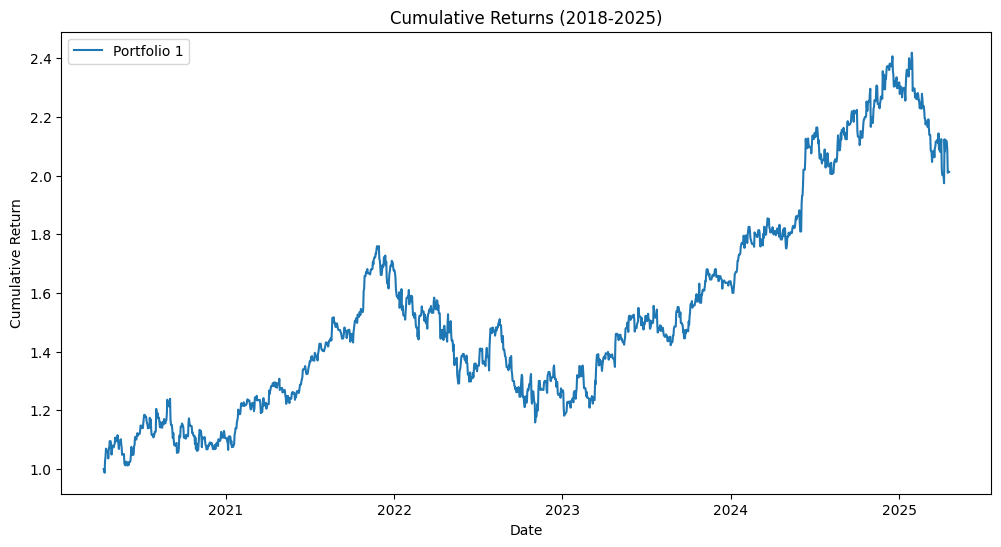

In [172]:
# Calculate cumulative returns for each portfolio
cumulative_returns_weighted = {}
cumulative_returns_weighted['Portfolio 1'] = (1 + returns_portfolio1).cumprod()


# Plot cumulative returns with manual weights
plt.figure(figsize=(12, 6))
for name, cumulative_return in cumulative_returns_weighted.items():
    plt.plot(cumulative_return, label=name)
plt.title('Cumulative Returns (2018-2025)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

In [173]:
weekly_dates = pd.date_range(
    start='2021-01-01',
    end='2025-04-20',
    freq='5M'
).strftime('%Y-%m-%d').tolist()



<ipython-input-173-9a321d99fc92>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  weekly_dates = pd.date_range(


In [174]:
i = 0
prices_portfolio = {}
returns_portfolio = {}
for k in range(len(weekly_dates) - 2):

  i = i + 1
  tickers = [
    'BTC-USD', # Bitcoin
    'SOL-USD', # Solana
    'ETH-USD', # Etherium
    'MSFT.MX', # Microsoft Corporation
    'GOOG', # Alphabet Inc. (Google)
    'WMT.MX', # Walmart Inc.
    'XOM', # Exxon Mobil Corporation
    'AZN.L', # AstraZeneca PLC
    'DIS.MX', # The Walt Disney Company
    'PG.MX', # The Procter & Gamble Company
    'KIM', # Kimco Realty Corporation
]


  start_date = weekly_dates[k]
  end_date = weekly_dates[k+1]
  period = '1d'

  print(start_date,end_date)


  bl = BlackLitterman(tickers, start_date, end_date, period)

  forecasts = bl.consolid_preds()
  mean_preds = forecasts.mean(axis=0)
  Q = pd.Series(mean_preds, index=tickers)

  P = pd.DataFrame(
    np.eye(len(tickers)),
    index=tickers,
    columns=tickers
)


  S           = bl.assets_returns.cov() * 252
  prior       = bl.implied_equil_returns()   # π
  confidences = [1, 1, 1, 1,1,1,1,1,1,1,1]




# Creating model
  bl2 = BlackLittermanModel(S, # Covariance Matrix
                         pi = prior, # Prior expected returns
                         Q = Q, # Vector of views
                         P = P, # Matrix mapping the views
                         omega = 'idzorek', # Confidence levels in %
                         view_confidences = confidences) # Confidences


  rets = bl2.bl_returns() # Calculating Expected returns
  ef = EfficientFrontier(rets, S) # Optimizing asset allocation

  ef.max_sharpe() # Optimizing weights for maximal Sharpe ratio
  weights1 = ef.clean_weights() # Cleaning weights
  weights1 # Printing weights

    # Define the portfolios
  portfolio1 = [    'BTC-USD',
      'SOL-USD',
      'ETH-USD',
      'MSFT.MX',
      'GOOG',
      'WMT.MX',
      'XOM',
      'AZN.L',
      'PG.MX',
      'KIM']

  # Download historical data from Yahoo Finance
  start_date = weekly_dates[k+1]
  end_date = weekly_dates[k+2]
  period = '1d'
  portfolios = {'Portfolio 1': portfolio1}


  # Fetch weekly adjusted close prices
  weekly_data = {}
  for name, tickers in portfolios.items():
      data = yf.download(tickers, start=start_date, end=end_date, interval=period)['Close']
      weekly_data[name] = data

  prices_portfolio = weekly_data['Portfolio 1']
  returns_portfolio[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)

2021-01-31 2021-06-30


[*********************100%***********************]  11 of 11 completed


Ticker       Date     AZN.L   BTC-USD    DIS.MX   ETH-USD      GOOG       KIM  \
0      2021-02-03 -0.010899  0.053774 -0.002766  0.091822  0.071353  0.000614   
1      2021-02-04  0.011306 -0.014679  0.024718 -0.040640 -0.003727  0.024244   
2      2021-02-05 -0.014736  0.032459 -0.005862  0.074815  0.017129  0.001197   
3      2021-02-08  0.001923  0.191527  0.048936  0.016141 -0.002429  0.019545   
4      2021-02-09  0.003150  0.006143 -0.008636  0.012188 -0.004501  0.008178   
..            ...       ...       ...       ...       ...       ...       ...   
93     2021-06-23 -0.003359  0.036767  0.001006  0.059420 -0.004245  0.007269   
94     2021-06-24  0.011113  0.027476 -0.000333 -0.000644  0.006467 -0.002417   
95     2021-06-25  0.009932 -0.091305 -0.002789 -0.092256 -0.002257  0.020126   
96     2021-06-28  0.019459  0.084702 -0.009249  0.137100 -0.001383 -0.011451   
97     2021-06-29  0.000923  0.040785 -0.014447  0.038261 -0.006336 -0.001921   

Ticker   MSFT.MX     PG.MX 

<ipython-input-167-b8409f1ff451>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
[                       0%                       ]

risk_aversion= 2.95


[*********************100%***********************]  10 of 10 completed
<ipython-input-174-3ebd6fbceed4>:91: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[**********************55%*                      ]  6 of 11 completed

2021-06-30 2021-11-30


[*********************100%***********************]  11 of 11 completed


Ticker       Date     AZN.L   BTC-USD    DIS.MX   ETH-USD      GOOG       KIM  \
0      2021-07-01  0.006772 -0.042818  0.010699 -0.073386  0.008364  0.010971   
1      2021-07-02  0.004223  0.009632 -0.004417  0.017091  0.018430 -0.009054   
2      2021-07-06 -0.006628  0.009926 -0.014058  0.078096  0.008140 -0.010587   
3      2021-07-07 -0.007250 -0.011158 -0.008222 -0.004103  0.002359  0.004345   
4      2021-07-08 -0.008001 -0.029312 -0.000478 -0.088051 -0.006947 -0.012603   
..            ...       ...       ...       ...       ...       ...       ...   
96     2021-11-22 -0.004255 -0.031998  0.009510 -0.050053 -0.019352  0.011248   
97     2021-11-23  0.004373  0.022481 -0.011607  0.059882 -0.002188  0.001656   
98     2021-11-24 -0.001062 -0.022639  0.011820 -0.023491 -0.000269  0.008237   
99     2021-11-26 -0.007108 -0.049362  0.002491 -0.050567 -0.027022 -0.047888   
100    2021-11-29 -0.005245  0.076118 -0.012551  0.097812  0.022900  0.001720   

Ticker   MSFT.MX     PG.MX 

<ipython-input-167-b8409f1ff451>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
[                       0%                       ]

risk_aversion= 2.95


[*********************100%***********************]  10 of 10 completed
<ipython-input-174-3ebd6fbceed4>:91: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[**********************64%******                 ]  7 of 11 completed

2021-11-30 2022-04-30


[*********************100%***********************]  11 of 11 completed


Ticker       Date     AZN.L   BTC-USD    DIS.MX   ETH-USD      GOOG       KIM  \
0      2021-12-01  0.004581  0.003929 -0.015474 -0.009652 -0.005872 -0.018911   
1      2021-12-02 -0.010033 -0.013227  0.026805 -0.016638  0.015127  0.050088   
2      2021-12-03 -0.004871 -0.052332 -0.011747 -0.066583 -0.008774 -0.011742   
3      2021-12-06  0.020781 -0.057908  0.025898  0.032180  0.008913  0.023347   
4      2021-12-07 -0.016882  0.002319 -0.003718 -0.010071  0.029060  0.008934   
..            ...       ...       ...       ...       ...       ...       ...   
92     2022-04-25 -0.004485  0.017906  0.008347  0.014917  0.029945  0.007051   
93     2022-04-26  0.009530 -0.059600 -0.024311 -0.069160 -0.030848 -0.017323   
94     2022-04-27  0.017272  0.029053 -0.007081  0.028307 -0.038256  0.002380   
95     2022-04-28  0.004745  0.013484  0.002044  0.016482  0.037465  0.043038   
96     2022-04-29  0.011859 -0.029702 -0.030495 -0.042193 -0.037935 -0.039479   

Ticker   MSFT.MX     PG.MX 

<ipython-input-167-b8409f1ff451>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
[                       0%                       ]

risk_aversion= 2.95


[*********************100%***********************]  10 of 10 completed
<ipython-input-174-3ebd6fbceed4>:91: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[                       0%                       ]

2022-04-30 2022-09-30


[*********************100%***********************]  11 of 11 completed


Ticker       Date     AZN.L   BTC-USD    DIS.MX   ETH-USD      GOOG       KIM  \
0      2022-05-04 -0.016801  0.050313  0.012018  0.054928  0.036942  0.010326   
1      2022-05-05  0.000571 -0.081941 -0.025872 -0.067314 -0.048718 -0.044847   
2      2022-05-06 -0.018240 -0.014714 -0.017658 -0.019924 -0.009350 -0.008716   
3      2022-05-09 -0.017789 -0.173608 -0.020865 -0.182493 -0.022524 -0.027040   
4      2022-05-10  0.010399  0.023679  0.000192  0.042753  0.013182 -0.026911   
..            ...       ...       ...       ...       ...       ...       ...   
93     2022-09-23  0.008221 -0.005989 -0.019744  0.000436 -0.014018 -0.018958   
94     2022-09-26  0.012896 -0.003892  0.005479  0.005302 -0.003637 -0.041797   
95     2022-09-27 -0.022224 -0.005850 -0.032169 -0.003896 -0.007313  0.006630   
96     2022-09-28  0.015301  0.016409  0.030232  0.005461  0.026658  0.026089   
97     2022-09-29 -0.014294  0.007504 -0.030698 -0.001316 -0.026658 -0.030504   

Ticker   MSFT.MX     PG.MX 

<ipython-input-167-b8409f1ff451>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
[                       0%                       ]

risk_aversion= 2.95


[*********************100%***********************]  10 of 10 completed
<ipython-input-174-3ebd6fbceed4>:91: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[**********************55%*                      ]  6 of 11 completed

2022-09-30 2023-02-28


[*********************100%***********************]  11 of 11 completed


Ticker       Date     AZN.L   BTC-USD    DIS.MX   ETH-USD      GOOG       KIM  \
0      2022-10-03 -0.013975  0.009822  0.017911 -0.003424  0.032236  0.017766   
1      2022-10-04  0.015382  0.035702  0.033776  0.028813  0.030839  0.031515   
2      2022-10-05 -0.001407 -0.008698  0.005632 -0.006843 -0.001857 -0.002070   
3      2022-10-06 -0.010717 -0.010234 -0.004105 -0.000834  0.000196 -0.007280   
4      2022-10-07  0.019328 -0.020688 -0.033586 -0.014300 -0.026462 -0.028052   
..            ...       ...       ...       ...       ...       ...       ...   
91     2023-02-21  0.007287 -0.005275 -0.017454 -0.021921 -0.027220 -0.033657   
92     2023-02-22 -0.006069 -0.010180 -0.015768 -0.008969 -0.002720 -0.003429   
93     2023-02-23 -0.025399 -0.010028  0.005054  0.004761 -0.007984  0.010737   
94     2023-02-24 -0.009861 -0.031792 -0.018936 -0.026203 -0.019067  0.001940   
95     2023-02-27 -0.000180  0.013902  0.000641  0.016008  0.008359 -0.000485   

Ticker   MSFT.MX     PG.MX 

<ipython-input-167-b8409f1ff451>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
[                       0%                       ]

risk_aversion= 2.95


[*********************100%***********************]  10 of 10 completed
<ipython-input-174-3ebd6fbceed4>:91: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[**********************45%                       ]  5 of 11 completed

2023-02-28 2023-07-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date     AZN.L   BTC-USD    DIS.MX   ETH-USD      GOOG       KIM  \
0      2023-03-01 -0.005900  0.021337 -0.026092  0.035203  0.002323 -0.005352   
1      2023-03-02  0.004428 -0.007261  0.008460 -0.009735  0.019692 -0.002442   
2      2023-03-03 -0.007391 -0.048562  0.009861 -0.048604  0.018355  0.010217   
3      2023-03-06 -0.003902  0.002995 -0.002919 -0.001128  0.016456 -0.008751   
4      2023-03-07  0.010004 -0.009406 -0.005380 -0.003493 -0.014862 -0.038323   
..            ...       ...       ...       ...       ...       ...       ...   
94     2023-07-24  0.000928 -0.024773 -0.015261 -0.022490  0.012965  0.001910   
95     2023-07-25 -0.005581  0.001728 -0.005190  0.004175  0.007439 -0.017325   
96     2023-07-26 -0.004675  0.004356 -0.002820  0.007731  0.054440  0.006291   
97     2023-07-27  0.002808 -0.004927 -0.003320 -0.006324  0.001618 -0.027385   
98     2023-07-28  0.032910  0.003709 -0.004740  0.007704  0.023890  0.000496   

Ticker   MSFT.MX     PG.MX 

<ipython-input-167-b8409f1ff451>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
[                       0%                       ]

risk_aversion= 2.95


[*********************100%***********************]  10 of 10 completed
<ipython-input-174-3ebd6fbceed4>:91: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[**********************45%                       ]  5 of 11 completed

2023-07-31 2023-12-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date     AZN.L   BTC-USD    DIS.MX   ETH-USD      GOOG       KIM  \
0      2023-08-01  0.000894  0.015130  0.010405  0.008385 -0.009208 -0.004452   
1      2023-08-02 -0.008972 -0.017808 -0.021396 -0.017626 -0.024950  0.001486   
2      2023-08-03 -0.017822  0.000916  0.007192 -0.002152  0.001010 -0.005958   
3      2023-08-04  0.000917 -0.003591 -0.005566 -0.004053 -0.001788 -0.003992   
4      2023-08-07 -0.002202  0.003656  0.000924 -0.000424  0.026107  0.006479   
..            ...       ...       ...       ...       ...       ...       ...   
96     2023-12-21 -0.000381  0.004957 -0.002075  0.016946  0.015207  0.004589   
97     2023-12-22 -0.004207  0.002931 -0.009616  0.038104  0.006467 -0.003670   
98     2023-12-27  0.008777 -0.012696 -0.016314  0.022195 -0.009009  0.000459   
99     2023-12-28  0.004360 -0.018938  0.008980 -0.013192 -0.001132  0.001377   
100    2023-12-29  0.002456 -0.012474 -0.001998 -0.020170 -0.002480 -0.022733   

Ticker   MSFT.MX     PG.MX 

<ipython-input-167-b8409f1ff451>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
[                       0%                       ]

risk_aversion= 2.95


[*********************100%***********************]  10 of 10 completed
<ipython-input-174-3ebd6fbceed4>:91: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[**********************64%******                 ]  7 of 11 completed

2023-12-31 2024-05-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date     AZN.L   BTC-USD    DIS.MX   ETH-USD      GOOG       KIM  \
0      2024-01-03 -0.004459 -0.048065  0.025089 -0.063559  0.005716 -0.026668   
1      2024-01-04  0.011479  0.030607 -0.021156  0.026019 -0.016667  0.004815   
2      2024-01-05 -0.009805 -0.000390 -0.006909 -0.000172 -0.004720  0.001440   
3      2024-01-08  0.001301  0.061639  0.001025  0.027985  0.022597  0.001438   
4      2024-01-09  0.011996 -0.017845 -0.004475  0.005043  0.014342 -0.006727   
..            ...       ...       ...       ...       ...       ...       ...   
92     2024-05-23  0.003553 -0.017407 -0.020927  0.010569 -0.016655 -0.022892   
93     2024-05-24 -0.008745  0.008743  0.006456 -0.013325  0.007229 -0.005400   
94     2024-05-28 -0.022037 -0.003360  0.014935  0.029953  0.009539 -0.013079   
95     2024-05-29 -0.008181 -0.010571 -0.008626 -0.020270 -0.003489  0.002739   
96     2024-05-30  0.008181  0.011577  0.009822 -0.004353 -0.021884  0.030705   

Ticker   MSFT.MX     PG.MX 

<ipython-input-167-b8409f1ff451>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
[                       0%                       ]

risk_aversion= 2.95


[*********************100%***********************]  10 of 10 completed
<ipython-input-174-3ebd6fbceed4>:91: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[**********************64%******                 ]  7 of 11 completed

2024-05-31 2024-10-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date     AZN.L   BTC-USD    DIS.MX   ETH-USD      GOOG       KIM  \
0      2024-06-03  0.012716  0.019273  0.038465  0.001691  0.002641  0.008743   
1      2024-06-04  0.004687  0.025300  0.011902  0.012173  0.004062 -0.012883   
2      2024-06-05  0.008989  0.007272 -0.032604  0.013481  0.011017  0.000518   
3      2024-06-06  0.005895 -0.004592  0.021224 -0.013720  0.007203 -0.002102   
4      2024-06-07 -0.002704 -0.020195  0.025582 -0.035510 -0.013548 -0.011640   
..            ...       ...       ...       ...       ...       ...       ...   
97     2024-10-24 -0.011223  0.025692 -0.009506  0.010072  0.000304 -0.000417   
98     2024-10-25 -0.007725 -0.022532  0.004309 -0.039666  0.014841 -0.016843   
99     2024-10-28  0.001894  0.047835  0.014577  0.051764  0.008052  0.013915   
100    2024-10-29 -0.008117  0.039447  0.000000  0.027911  0.016496 -0.008833   
101    2024-10-30 -0.028850 -0.005252  0.001037  0.007333  0.028797  0.014678   

Ticker   MSFT.MX     PG.MX 

<ipython-input-167-b8409f1ff451>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
[                       0%                       ]

risk_aversion= 2.95


[*********************100%***********************]  10 of 10 completed
<ipython-input-174-3ebd6fbceed4>:91: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)


In [175]:
dfs2 = [returns_portfolio[f'return_{i}'] for i in range(1, 9)]

# Concatenate them side by side (columns)
combined_df2 = pd.concat(dfs2, axis=0)

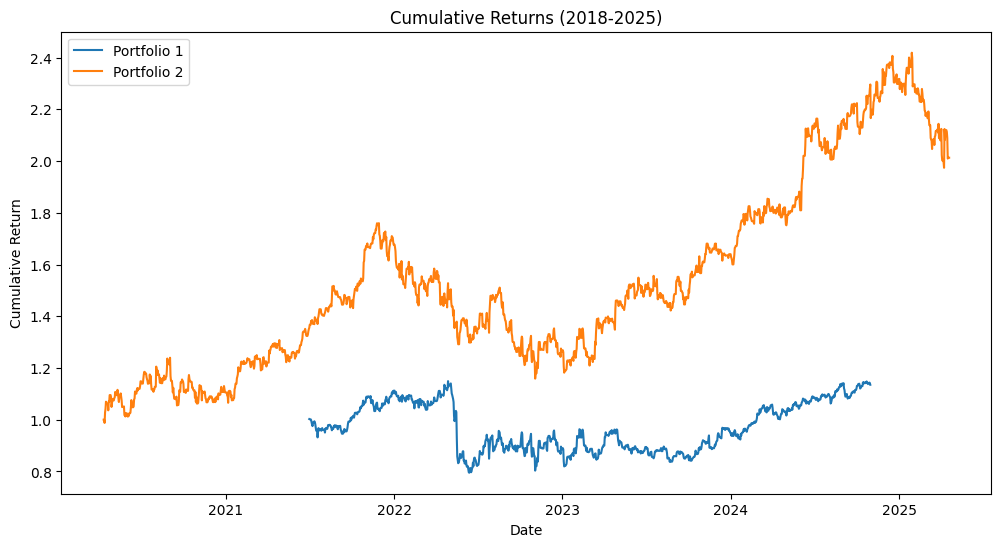

In [176]:
# Calculate cumulative returns for each portfolio
cumulative_returns_weighted = {}
cumulative_returns_weighted['Portfolio 1'] = (1 + combined_df2).cumprod()
cumulative_returns_weighted['Portfolio 2'] = (1 + returns_portfolio1).cumprod()



# Plot cumulative returns with manual weights
plt.figure(figsize=(12, 6))
for name, cumulative_return in cumulative_returns_weighted.items():
    plt.plot(cumulative_return, label=name)
plt.title('Cumulative Returns (2018-2025)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()